## SMLT-01 - Time Series
Affandy Fahrizain - J42332c

In [106]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import tsa
import warnings
from itertools import product
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
from sklearn.metrics import r2_score

import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv('./DailyDelhiClimateTrain.csv',
                  parse_dates=['date'], index_col='date')
data.head(30)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
2013-01-06,7.000000,82.800000,1.480000,1018.000000
2013-01-07,7.000000,78.600000,6.300000,1020.000000
2013-01-08,8.857143,63.714286,7.142857,1018.714286
2013-01-09,14.000000,51.250000,12.500000,1017.000000


Seems the data pretty rigid timesteps. Let's now see the plot of the data and decompose time series attributes!

In [4]:
# take only subset for a year
data = data.loc['2016':'2016']
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-01-01,14.714286,72.285714,1.057143,1021.142857
2016-01-02,14.000000,75.875000,2.087500,1021.000000
2016-01-03,14.375000,74.750000,5.112500,1018.500000
2016-01-04,15.750000,77.125000,0.000000,1017.625000
2016-01-05,15.833333,88.833333,0.616667,1017.000000


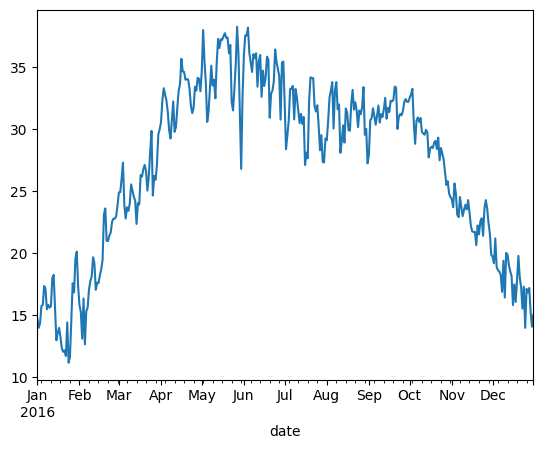

In [5]:
data.meantemp.plot()
plt.show()

### ARIMA Approach

Dicky-Fuller test: p=0.8286516553555878


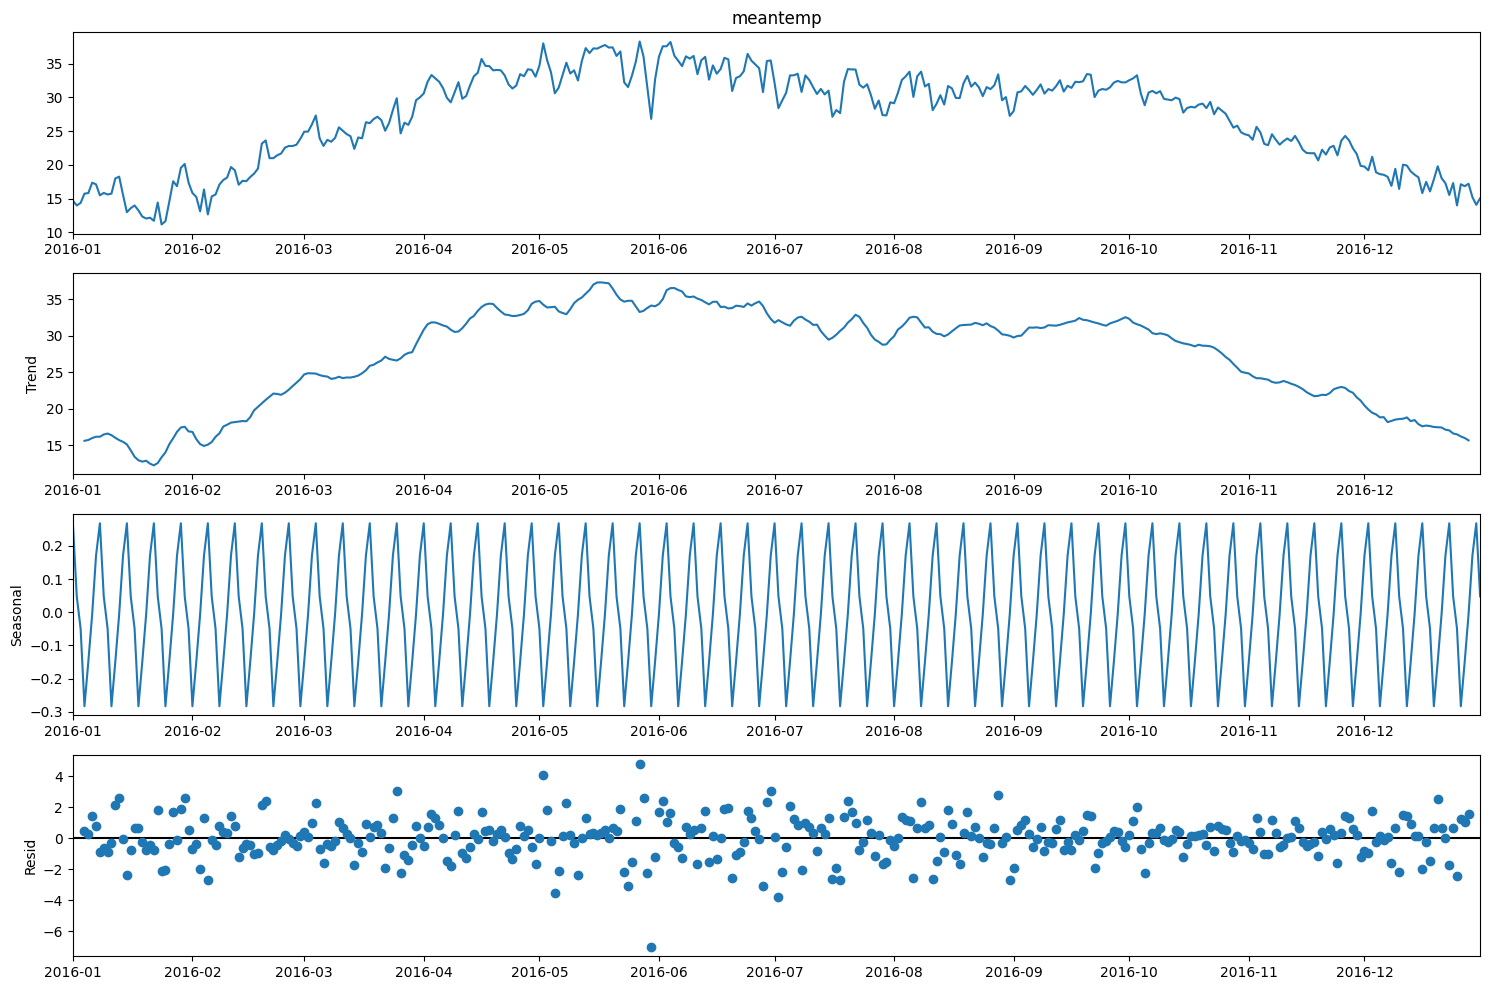

In [6]:
plt.rc("figure", figsize=(15,10))
tsa.seasonal_decompose(data.meantemp).plot()
print(f'Dicky-Fuller test: p={tsa.stattools.adfuller(data.meantemp)[1]}')

We got p-value **> 0.05** for Dicky-Fuller test, which means we **cannot reject the null hypothesis** in other words **our data is not stationary**. It also clearly depicted from our seasonality decomposition plots which indicated inconstant variance. Hence, we need to perform operations to make our data become stationary. 
<br><br>
There are several operations available:
- Taking difference
- Seasonal derivative
- Dispersion normalization (Box-Cox transformation)
<br><br>

And after each operation we did, we will perform Dicky-Fuller test again to see if our data already stationary.

ADF statistics: -3.321964317622925
Dicky-Fuller test: p=0.013924765642623467


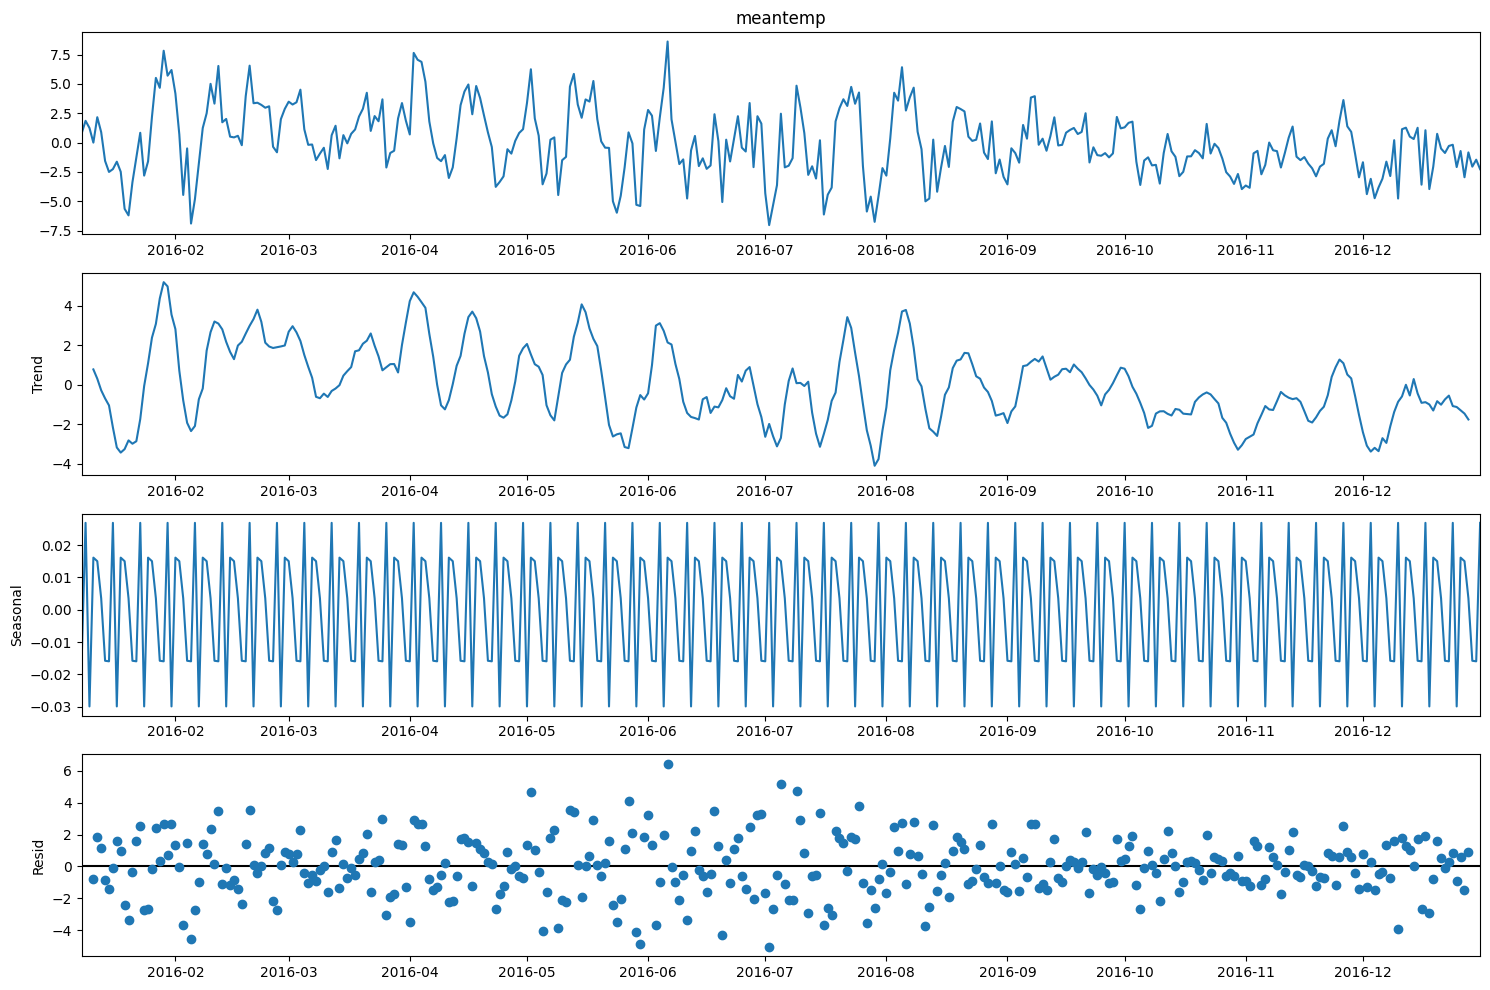

In [7]:
# taking seasonal difference for 7 days
meantemp_diff = data.meantemp.diff(7).dropna()

# Dicky-Fuller test
adftest = tsa.stattools.adfuller(meantemp_diff)

# plot seasonal decompose
plt.rc("figure", figsize=(15,10))
tsa.seasonal_decompose(meantemp_diff).plot()
print(f'ADF statistics: {adftest[0]}')
print(f'Dicky-Fuller test: p={adftest[1]}')
plt.show()

Now we have stationary data, proven by **p-value < 0.05**. Also, seasonality decompose results shown that our data have **zero-trend** and quite **constant variance**.

<br>

Next, we want to train ARIMA model. But first, we need to know which appropriate p and q values for ARIMA model. Hence, we will try to plot ACF and PACF to get insight for our p and q values.<br><br>
> **Important Notes!** <br>
> In order to plot ACF and PACF, our data **need to be stationary**. If the ACF values are **very high and slowly tailed off**, it's a sign that our data is **non-stationary**, hence it needs to be differenced. On the other hand, if the ACF value **at lag-1 is very negative**, it's a sign that we **difference it too much**. Also, note that ACF and PACF values at lag-0 is always 1, hence we can skip it to make the plot simpler.

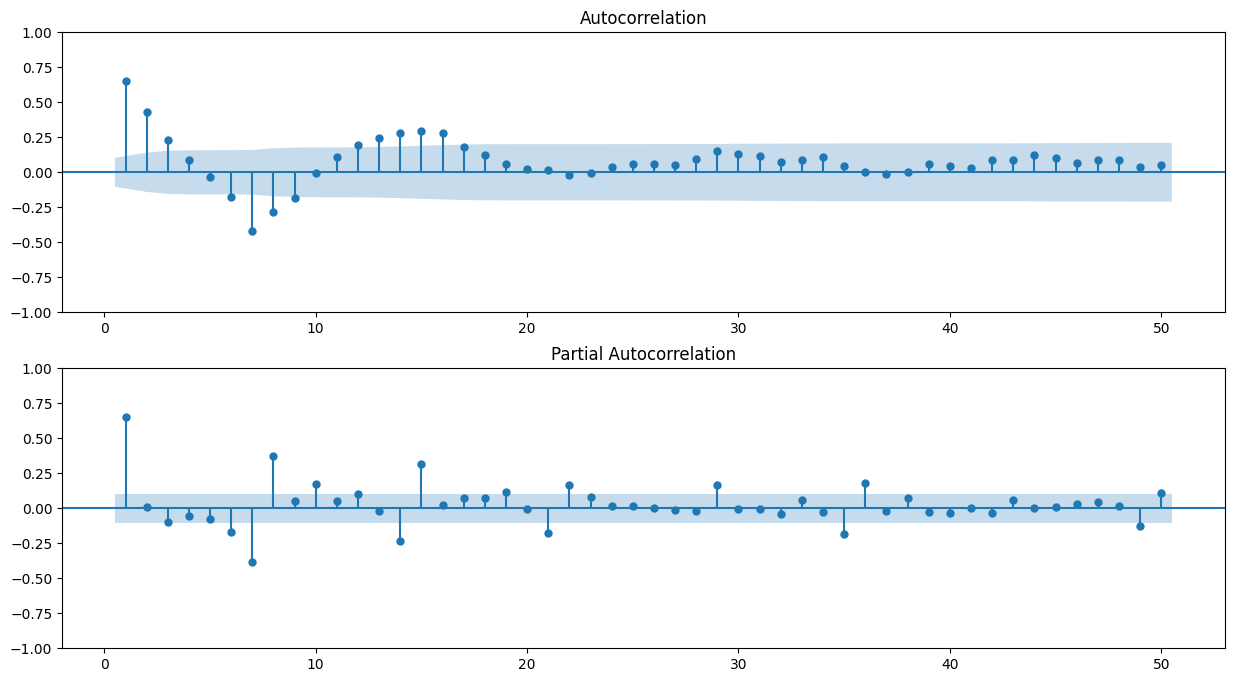

In [8]:
# plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

sm.graphics.tsa.plot_acf(meantemp_diff, lags=50, zero=False, ax=ax1)
sm.graphics.tsa.plot_pacf(meantemp_diff, lags=50, zero=False, ax=ax2)
plt.show()

As both ACF and PACF plot shown tailed off, its not straightforward to determine p and q values.

Next, we will try to use AIC and BIC to help us finding the most appropriate p and q values. **Lower values** indicate **better** models for both metrics. The difference is, if we want a **good predictive model** then we choose model with the **lowest AIC** value. But, if we want **better explanatory model** then we choose model with the **lowest BIC** value.

In [10]:
# parameters for SARIMA model
# as suggested by professor, better use values < 10
# p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use
# q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use
# d - show how many times have we derivated our series 1-step-wise
# D - show how many times have we derivated our series Period-step-wise
ps = range(0, 11)   # 10
d = 1
qs = range(0, 11)  # 10
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 242


In [15]:
results = []
best_aic = float('inf')

for params in tqdm(parameters_list):
    try:
        model = tsa.statespace.SARIMAX(data.meantemp, order=(params[0], d, params[1]),
                                       seasonal_order=(params[2], D, params[3], 7)).fit(disp=-1)
    except:
        continue
    
    if model.aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = params
        results.append([params, model.aic])

  0%|          | 0/242 [00:00<?, ?it/s]

In [16]:
results = pd.DataFrame(results, columns=['params', 'aic'])
results.sort_values('aic').head()

,params,aic
17,"(7, 8, 0, 0)",1370.025147
16,"(3, 8, 1, 0)",1370.773397
15,"(1, 10, 1, 0)",1371.246151
14,"(1, 10, 0, 0)",1371.558210
13,"(1, 9, 1, 0)",1371.600306


In [11]:
best_model = model = tsa.statespace.SARIMAX(data.meantemp, order=(7, d, 8),
                                       seasonal_order=(0, D, 0, 7)).fit(disp=-1)

In [12]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           meantemp   No. Observations:                  366
Model:             SARIMAX(7, 1, 8)x(0, 1, [], 7)   Log Likelihood                -668.978
Date:                            Tue, 20 Sep 2022   AIC                           1369.956
Time:                                    19:44:58   BIC                           1432.044
Sample:                                01-01-2016   HQIC                          1394.648
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5741      0.069      8.316      0.000       0.439       0.709
ar.L2          0.0610      0.065      0.932      0.351      -0.067       0.189
ar.L3         -0.1553      0.066     -2.340      0.019      -0.285      -0.025
ar.L4         -0.0110      0.073     -0.150      0.880      -0.154       0.132
ar.L5         -0.0128      0.072     -0.177      0.859      -0.154       0.128
ar.L6          0.1064      0.065      1.628      0.104      -0.022       0.234
ar.L7         -0.1885      0.060     -3.155      0.002      -0.306      -0.071
ma.L1         -0.8226      0.095     -8.680      0.000      -1.008      -0.637
ma.L2         -0.0876      0.128     -0.683      0.495      -0.339       0.164
ma.L3          0.0909      0.153      0.596      0.551      -0.208       0.390
ma.L4         -0.0643      0.033     -1.934      0.053      -0.130       0.001
ma.L5          0.1217      0.166      0.731      0.464      -0.204       0.448
ma.L6         -0.0395      0.120     -0.328      0.743      -0.276       0.197
ma.L7         -0.9641      0.172     -5.600      0.000      -1.302      -0.627
ma.L8          0.8321      0.121      6.861      0.000       0.594       1.070
sigma2         2.3188      0.302      7.684      0.000       1.727       2.910
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.52
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

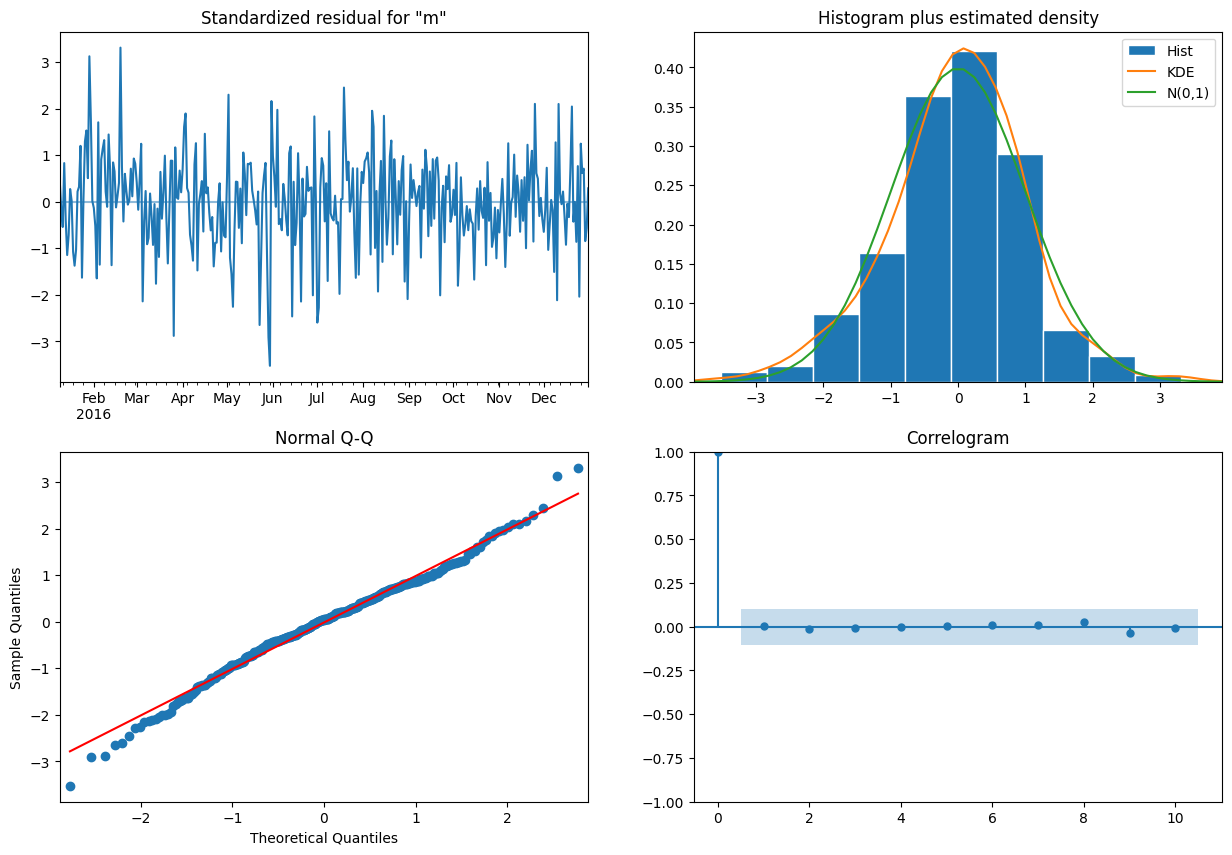

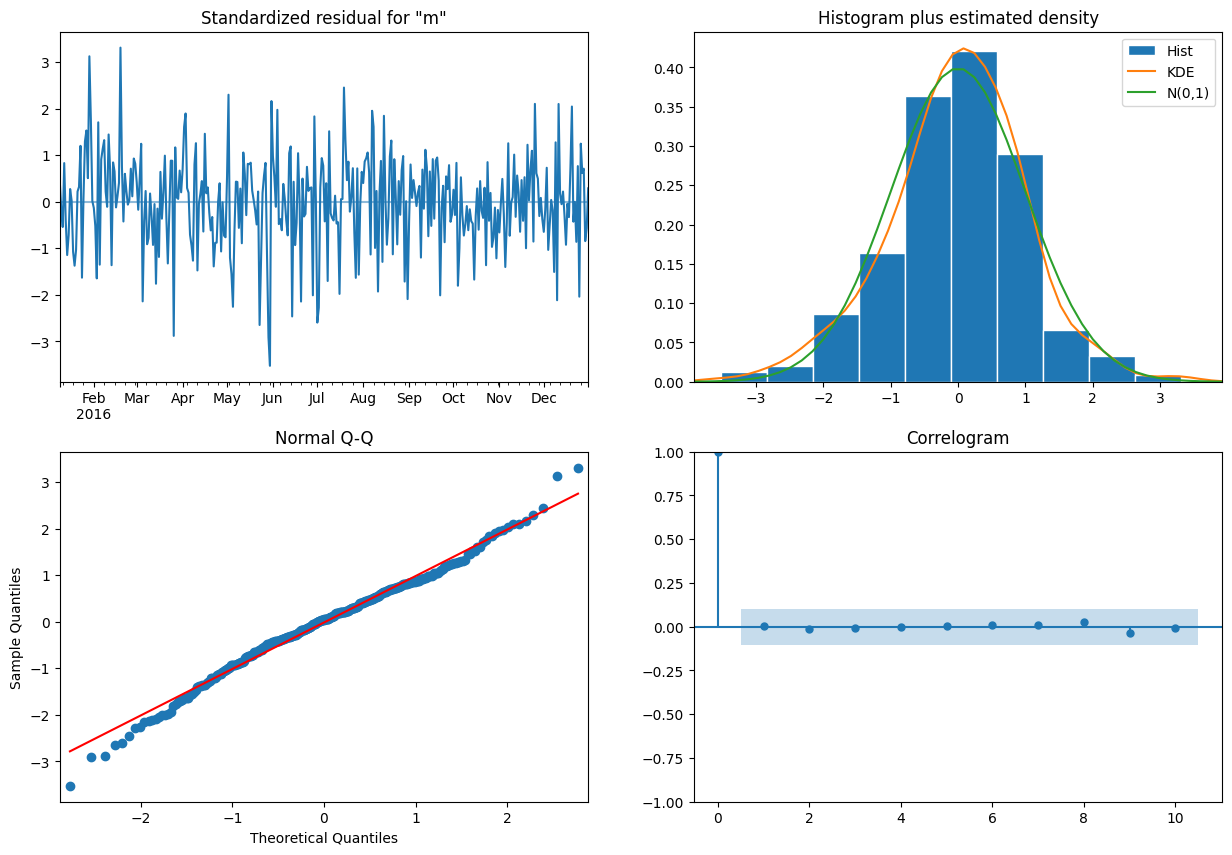

In [50]:
best_model.plot_diagnostics()

Dickey-Fuller test: p=0.0


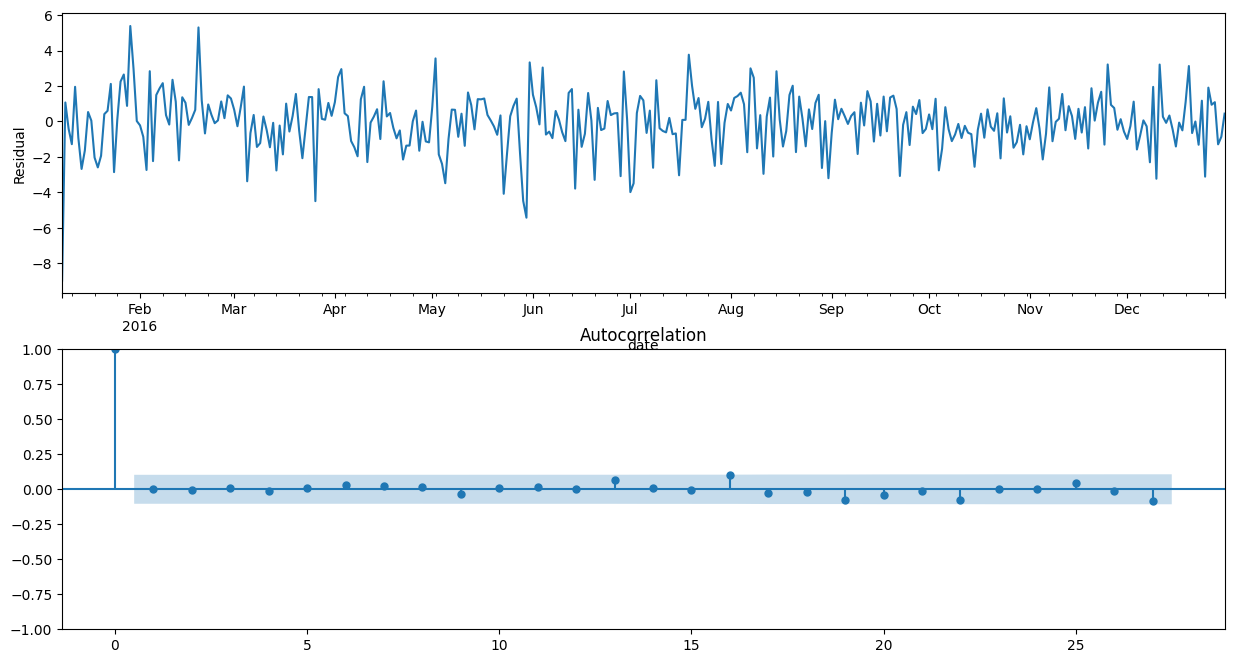

In [14]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
best_model.resid[7:].plot()
plt.ylabel('Residual')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[7:].values.squeeze(), lags=27, ax=ax)

print(f'Dickey-Fuller test: p={tsa.stattools.adfuller(best_model.resid[7:])[1]}')

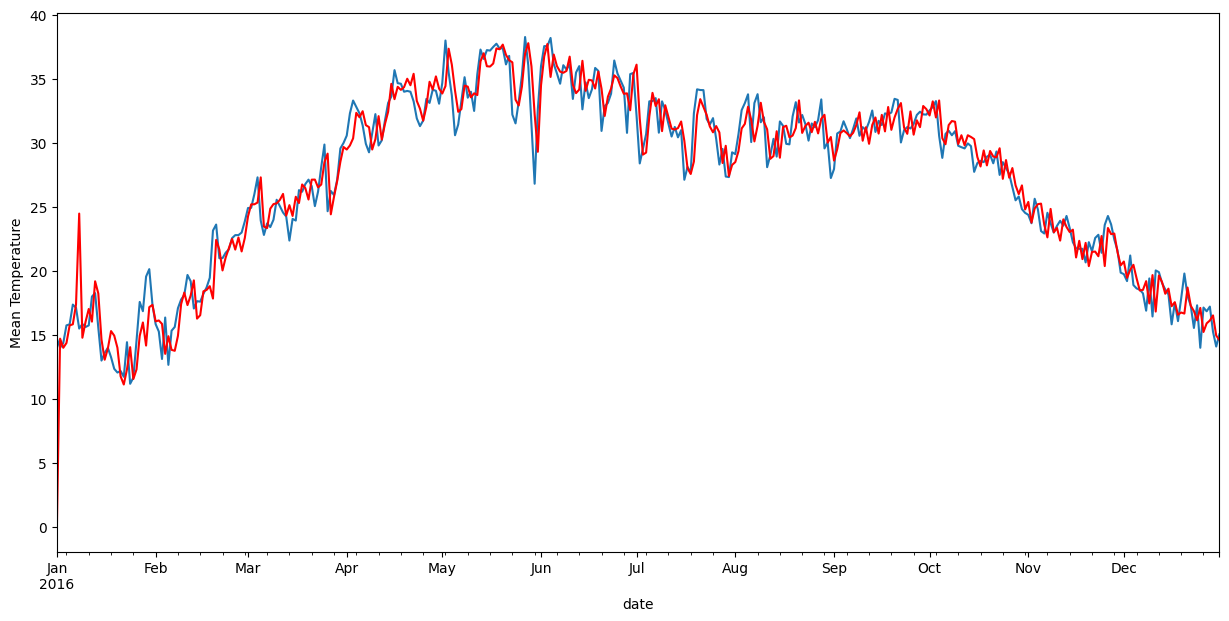

In [15]:
plt.figure(figsize=(15, 7))
data.meantemp.plot()
best_model.fittedvalues.plot(color='r')
plt.ylabel('Mean Temperature')
plt.show()

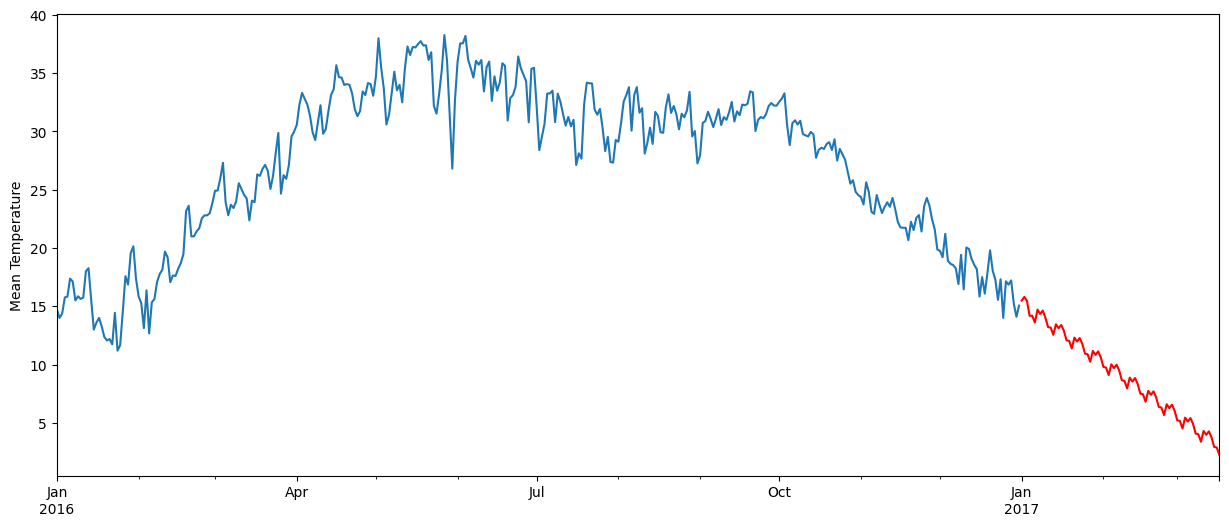

In [47]:
# make prediction

datameantemp = data[['meantemp']]
future = best_model.predict(start=366, end=441).to_frame(name='forecast')
fulldata = pd.concat([datameantemp, future])

plt.figure(figsize=(15, 6))
fulldata.meantemp.plot()
fulldata.forecast.plot(color='r')
plt.ylabel('Mean Temperature')
plt.show()

In [67]:
# evaluation
test_set = datameantemp.iloc[-1 * int(1/5 * len(datameantemp)):]
best_fit = best_model.fittedvalues.iloc[-1 * len(test_set):]
y_true = test_set.values.squeeze()
y_pred = best_fit.values

In [70]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 3)

print(f'MAPE: {mape(y_true, y_pred)}')
print(f'R^2: {round(r2_score(y_true, y_pred), 3)}')

MAPE: 5.063
R^2: 0.882


### LSTM Approach

In [801]:
# data preparation
def make_lags(data, n_past=1, n_future=1, dropnan=True):    
    data_lags = data.copy()    

    # get past lags. ex: (t-n, t-n+1, ... t)
    for n in range(n_past, 0, -1):
        colname = f'meantemp(t-{n})'
        data_lags[colname] = data_lags['meantemp'].shift(-n)
    
    # get future shift. ex: (t+1, t+2, ... t+n)
    for n in range(0, n_future+1):
        colname = f'meantemp(t+{n})'
        if n == 0:
            colname = 'meantemp(t)'        
        data_lags[colname] = data_lags['meantemp'].shift(n)
    
    if dropnan:
        data_lags.dropna(inplace=True)

    data_lags.drop('meantemp', axis=1, inplace=True)
    
    return data_lags

def difference(data, interval=1):
    return data.diff(interval).dropna()

def prepare_data(data, lag_size, diff_size, n_test, n_past=None, n_future=None, return_tensor=True):
    # take difference
    data_diff = difference(data, diff_size)
    
    # scale data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_diff['meantemp'] = scaler.fit_transform(data_diff.values.reshape(-1, 1))

    # make lags
    if n_past is None and n_future is None:
        n_past = n_future = lag_size

    data_lags = make_lags(data_diff, n_past, n_future)

    # split train test data
    train, test = data_lags[0 : -n_test], data_lags[-n_test:]

    if return_tensor:
        train, test = torch.from_numpy(train.to_numpy()).float(), torch.from_numpy(test.to_numpy()).float()
        # make feature and target
        train = train[:, :n_past], train[:, n_past:]
        test = test[:, :n_past], test[:, n_past:]

    return scaler, train, test

In [802]:
# model
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(LSTMForecast, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first=True).float()
        self.dense = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x = x.double()
        out, _ = self.lstm(x)        
        # get only last sequence output
        out = out[:, -1, :]        
        # pass to dense layer
        out = self.dense(out)        

        return out

    def train_model(self, traindata, val_split=0.1, epochs=30):       
        X_train, y_train = traindata
        X_train = X_train.unsqueeze(dim=1)  # reshape tensor to (batch_size, seq_length, hidden)

        # make validation split
        val_size = int(len(X_train) * val_split)
        X_train, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train, y_val = y_train[:-val_size], y_train[-val_size:]

        # training config
        history = {'train_loss': [],
                   'val_loss': [],
                   'epochs': list(range(epochs))}
        lr = 0.001
        criterion = nn.MSELoss()
        optim = Adam(self.parameters(), lr=lr)

        for e in tqdm(range(epochs)):

            # put to train mode
            self.train()

            # forward pass
            y_pred = self.forward(X_train)

            # loss fn
            train_loss = criterion(y_train, y_pred.squeeze())            
            history['train_loss'].append(train_loss.item())
            train_loss.backward()

            # optimizer
            optim.step()
            optim.zero_grad()

            
            # validation
            self.eval()
            # turn off autograd
            with torch.no_grad():
                # forward pass
                y_pred_v = self.forward(X_val)
                # loss fn
                val_loss = criterion(y_val, y_pred_v.squeeze())
                history['val_loss'].append(val_loss.item())

            print(f'[{e+1}/{epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')            

        return history

    def predict(self, testdata):
        X_test, y_test = testdata
        forecasts = list()

        for x in X_test:
            # reshape input
            x = x.reshape(1, 1, len(x))
            # forward pass
            y_pred_i = self.forward(x).detach()
            forecasts.append(y_pred_i.squeeze().numpy())
        
        return forecasts            

In [803]:
lag_size = 7
diff_size = 1
n_test = 73

_, train_df, test_df = prepare_data(datameantemp, lag_size, diff_size, n_test, return_tensor=False)

In [804]:
scaler, train, test = prepare_data(datameantemp, lag_size, diff_size, n_test, return_tensor=True)

In [805]:
input_size = train[0].shape[1]
hidden_size = 8
out_size = train[1].shape[1]
val_split = 0.1
epochs = 30

model = LSTMForecast(input_size, hidden_size, out_size)
model = model.float()

In [806]:
history = model.train_model(train, val_split, epochs)

100%|██████████| 30/30 [00:00<00:00, 719.34it/s]

[1/30] Train Loss: 0.1479 | Val Loss: 0.0821
[2/30] Train Loss: 0.1473 | Val Loss: 0.0814
[3/30] Train Loss: 0.1467 | Val Loss: 0.0808
[4/30] Train Loss: 0.1460 | Val Loss: 0.0802
[5/30] Train Loss: 0.1454 | Val Loss: 0.0796
[6/30] Train Loss: 0.1448 | Val Loss: 0.0789
[7/30] Train Loss: 0.1442 | Val Loss: 0.0783
[8/30] Train Loss: 0.1436 | Val Loss: 0.0777
[9/30] Train Loss: 0.1430 | Val Loss: 0.0771
[10/30] Train Loss: 0.1424 | Val Loss: 0.0765
[11/30] Train Loss: 0.1418 | Val Loss: 0.0759
[12/30] Train Loss: 0.1412 | Val Loss: 0.0753
[13/30] Train Loss: 0.1406 | Val Loss: 0.0748
[14/30] Train Loss: 0.1400 | Val Loss: 0.0742
[15/30] Train Loss: 0.1394 | Val Loss: 0.0736
[16/30] Train Loss: 0.1389 | Val Loss: 0.0730
[17/30] Train Loss: 0.1383 | Val Loss: 0.0725
[18/30] Train Loss: 0.1377 | Val Loss: 0.0719
[19/30] Train Loss: 0.1372 | Val Loss: 0.0713
[20/30] Train Loss: 0.1366 | Val Loss: 0.0708
[21/30] Train Loss: 0.1361 | Val Loss: 0.0703
[22/30] Train Loss: 0.1356 | Val Loss: 0.06

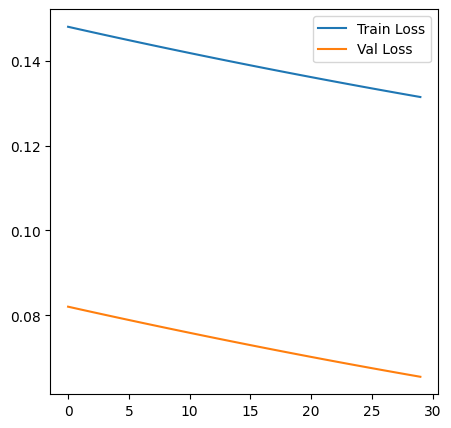

In [807]:
plt.figure(figsize=(5, 5))
plt.plot(history['epochs'], history['train_loss'], label='Train Loss')
plt.plot(history['epochs'], history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [831]:
forecasts = model.predict(test)

In [856]:
def inverse_diff(last_obs, inv_scaled_forecast):
    invert_diff = list()
    invert_diff.append(inv_scaled_forecast[0] + last_obs)
    for i in range(1, len(inv_scaled_forecast)):
        invert_diff.append(inv_scaled_forecast[i] + invert_diff[i-1])

    return invert_diff

def inverse_transform(data, forecast, scaler, n_test):
    inverted = list()
    for i, f in enumerate(forecast):
        f = f.reshape(1, len(f))
        inv_scale = scaler.inverse_transform(f)[0, :]        
        index = len(data) - n_test + i - 1        
        last_obs = data.values[index]
        inv_diff = inverse_diff(last_obs, inv_scale)
        inverted.append(inv_diff)
    
    return inverted

In [857]:
inv_forecast = np.array(inverse_transform(datameantemp, forecasts, scaler, n_test))
aligned_forecast = np.array(list(inv_forecast[:, 0]) + list(inv_forecast[-1, 1:]))

In [858]:
y_true = datameantemp.values[-len(aligned_forecast):]

print(f'R^2 score: {r2_score(y_true, aligned_forecast)}')
print(f'MAPE: {mape(y_true, aligned_forecast)}')

R^2 score: 0.7667245949616541
MAPE: 8.045


In [859]:
fulldatalstm = datameantemp.copy()
fulldatalstm['predicted'] = np.nan
fulldatalstm.iloc[-len(aligned_forecast):, 1] = aligned_forecast

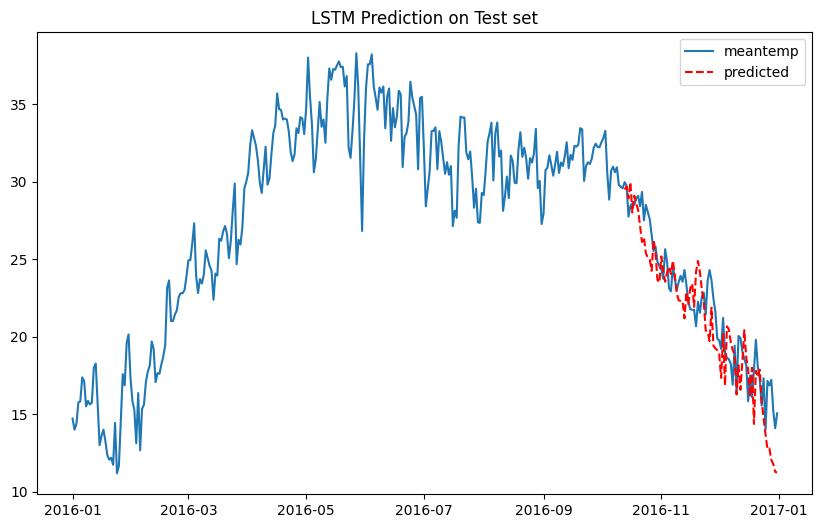

In [860]:
plt.figure(figsize=(10, 6))
plt.plot(fulldatalstm.meantemp, label='meantemp')
plt.plot(fulldatalstm.predicted, 'r--', label='predicted')
plt.legend()
plt.title('LSTM Prediction on Test set')
plt.show()

In [1054]:
# # make forecast for the future
infer_df = datameantemp.iloc[-8:]
infer_df['lstm_forecast'] = infer_df
infer_df

,meantemp,lstm_forecast
date,,
2016-12-24,17.318182,17.318182
2016-12-25,14.000000,14.000000
2016-12-26,17.142857,17.142857
2016-12-27,16.850000,16.850000
2016-12-28,17.217391,17.217391
2016-12-29,15.238095,15.238095
2016-12-30,14.095238,14.095238
2016-12-31,15.052632,15.052632


In [1055]:
n_forecast = 76

for i in range(n_forecast):
    # take difference
    infer_diff = infer_df[['lstm_forecast']].diff(1).dropna()
    # get past 7-days data
    infer = infer_diff.iloc[-7:]
    # scale and convert to tensor
    infer = torch.from_numpy(
        scaler.fit_transform(infer)
    ).float()
    # reshape
    infer = infer.reshape(1, 1, 7)
    # forward pass
    out = model(infer).detach()    
    # inverse transform
    inv_forecast = inverse_transform(infer_df[['lstm_forecast']], out, scaler, 1)[0][0]    # get only t+1 prediction
    # add new predicted data
    new_date = infer_df.index[-1] + pd.Timedelta(days=1)
    new_df = pd.DataFrame(data={'meantemp': np.nan, 'lstm_forecast': inv_forecast}, index=[new_date])
    infer_df = pd.concat([infer_df, new_df])
    
# null-ing the copied real values of meantemp
infer_df.iloc[:8, 1] = np.nan

In [1056]:
datameantemp_cp = datameantemp.copy()
lstm_data = pd.concat([datameantemp_cp, infer_df[['lstm_forecast']].dropna()])

In [1059]:
final_data = pd.concat([fulldata, lstm_data[['lstm_forecast']]], axis=1)

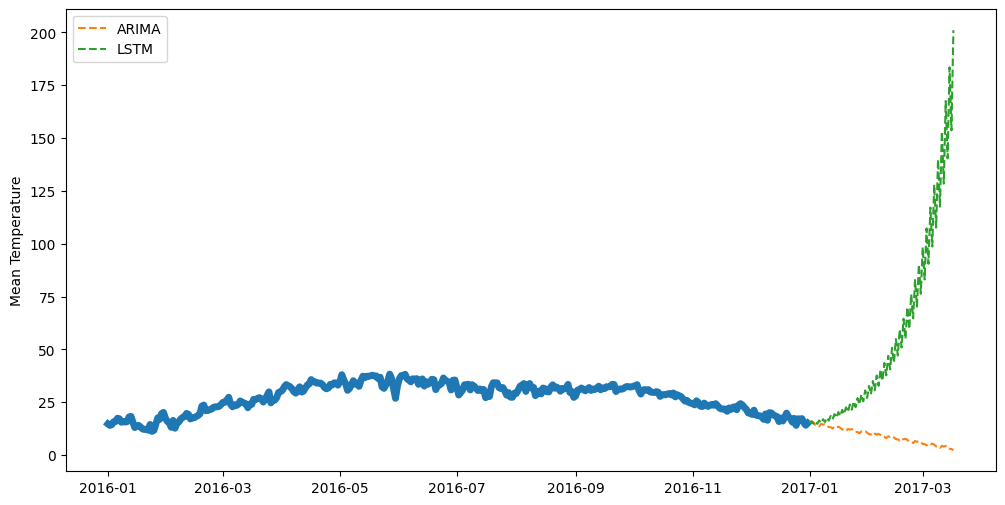

In [1060]:
plt.figure(figsize=(12, 6))
plt.plot(final_data[['meantemp']], linewidth=5)
plt.plot(final_data[['forecast']], '--', label='ARIMA')
plt.plot(final_data[['lstm_forecast']], '--', label='LSTM')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

### Conclusion

| Model | R^2   | MAPE  |
|-------|-------|-------|
| ARIMA | **0.882** | **5.063** |
| LSTM  | 0.766 | 8.045 |

Based on the evaluation result, ARIMA shows better performance. It can be seen in the table above, ARIMA has higher R^2 score and lower MAPE score compared to LSTM. And, based on the plot result, both ARIMA and LSTM seems suffering in predicting long sequences. Nevertheless, LSTM output seems more unrealistic compared to ARIMA results. 

As the used data is captured for one-year period only, the model didn't have any further information about yearly seasonality, which we assumed as one of the main reason of its suffers on predicting long sequences.